In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ansim_dataset_unconf import ansimDataset, create_circular_mask, ansimDataset_orientation
# from convolution_lstm import encoderConvLSTM, decoderConvLSTM
from ConvLSTM_unconf import MtConvLSTM
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
import scipy.ndimage
import cv2
import scipy.misc
from array2gif import write_gif
from scipy.misc import imsave
import pickle

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
img_path = '/home/rliu/ansim/data/unconfined_steph/cropped_orientation/'
img_list_csv = '/home/rliu/github/ansim/unconfined_orientation/img_list.csv'
train_csv = '/home/rliu/github/ansim/unconfined_orientation/train_unconf.csv'
test_csv = '/home/rliu/github/ansim/unconfined_orientation/test_unconf.csv'
output_path = '/home/rliu/ansim/models/dataset3/6-17_mt_paper_orientation/final.weights'

In [4]:
mask = create_circular_mask(128,128)

testset = ansimDataset_orientation(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path, step=20, random_rotate = False, transform=None, image_size = 128, rand_range=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False,
                                                     num_workers=1)

In [5]:
model = torch.load('/home/rliu/ansim/models/dataset3/6-17_mt_paper_orientation/0180.weights')
model = model.module

/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'ConvLSTM_unconf.MtConvLSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the ob

In [6]:
dataiter = iter(testloader)
for i in range(6):
    images = dataiter.next()
    data_split = torch.split(images, (5,15), dim=1)
    inputs_t = data_split[0]
    target_t = data_split[1]
    inputs_t, target_t = inputs_t.cuda(), target_t.cuda()

In [7]:
layer_output_list, last_state_list, pred_output, pred_a = model(inputs_t)

/home/rliu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [14]:
a = (layer_output_list, last_state_list, pred_output, pred_a)
with open('data.pickle', 'wb') as f:
    pickle.dump(a, f)
with open('data.pickle', 'rb') as f:
    a = pickle.load(f)
(layer_output_list, last_state_list, pred_output, pred_a) = a 
_,_,_, pred_b = model.forecast(layer_output_list, last_state_list, pred_output, pred_a, predict_steps = 10)

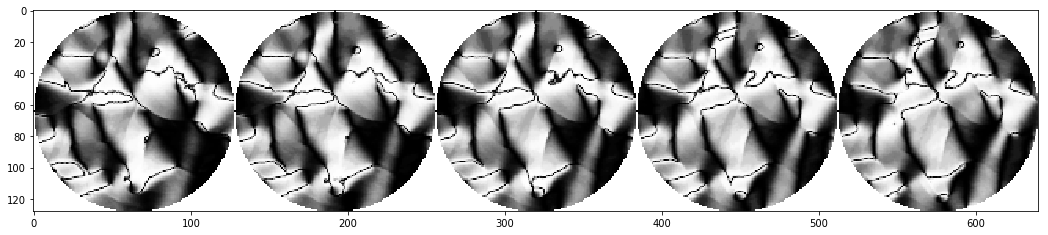

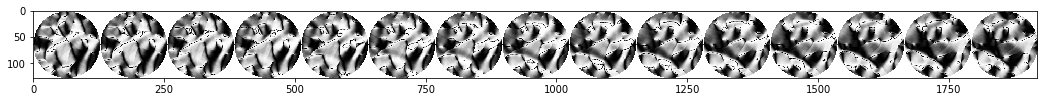

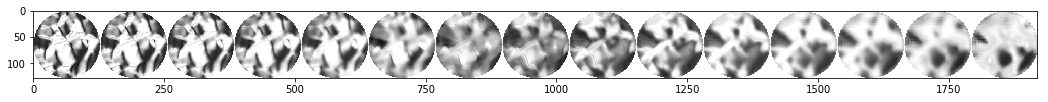

In [16]:
pred_t = torch.cat((pred_a, pred_b), 1)
predicted = pred_t[0,:,0,:,:].cpu().detach().numpy()
target = target_t[0,:,0,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = (inputs + 0.5) * 255
target = (target + 0.5) * 255
predicted = (predicted + 0.5) * 255

inputs = inputs.reshape(640,128).transpose().astype(int)
target = target.reshape(1920,128).transpose().astype(int)
predicted = predicted.reshape(1920,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)